## ResNet在眼疾识别数据集iChallenge-PM上的应用

[iChallenge-PM](https://ai.baidu.com/broad/introduction)是百度大脑和中山大学中山眼科中心联合举办的iChallenge比赛中，提供的关于病理性近视（Pathologic Myopia，PM）的医疗类数据集，包含1200个受试者的眼底视网膜图片，训练、验证和测试数据集各400张。





### 数据集准备

/home/aistudio/data/data19065 目录包括如下三个文件，解压缩后存放在/home/aistudio/work/palm目录下。
- training.zip：包含训练中的图片和标签
- validation.zip：包含验证集的图片
- valid_gt.zip：包含验证集的标签

------
**注意**：

valid_gt.zip文件解压缩之后，需要将“/home/aistudio/work/palm/PALM-Validation-GT/”目录下的“PM_Label_and_Fovea_Location.xlsx”文件转存成.csv格式，本代码中已经提前转成文件PM_Label_and_Fovea_Location.csv。

------

In [ ]:
# 初次运行时将注释取消，以便解压文件
# 如果已经解压过，不需要运行此段代码，否则由于文件已经存在，解压时会报错
!unzip -o -q -d /home/aistudio/work/palm /home/aistudio/data/data19065/training.zip
%cd /home/aistudio/work/palm/PALM-Training400/
!unzip -o -q PALM-Training400.zip
!unzip -o -q -d /home/aistudio/work/palm /home/aistudio/data/data19065/validation.zip
!unzip -o -q -d /home/aistudio/work/palm /home/aistudio/data/data19065/valid_gt.zip
#返回家目录，生成模型文件位于/home/aistudio/
%cd /home/aistudio/


/home/aistudio/work/palm/PALM-Training400
/home/aistudio


### 查看数据集图片

iChallenge-PM中既有病理性近视患者的眼底图片，也有非病理性近视患者的图片，命名规则如下：

- 病理性近视（PM）：文件名以P开头

- 非病理性近视（non-PM）：

  * 高度近视（high myopia）：文件名以H开头
  
  * 正常眼睛（normal）：文件名以N开头

我们将病理性患者的图片作为正样本，标签为1； 非病理性患者的图片作为负样本，标签为0。从数据集中选取两张图片，将图片显示出来。代码如下所示：

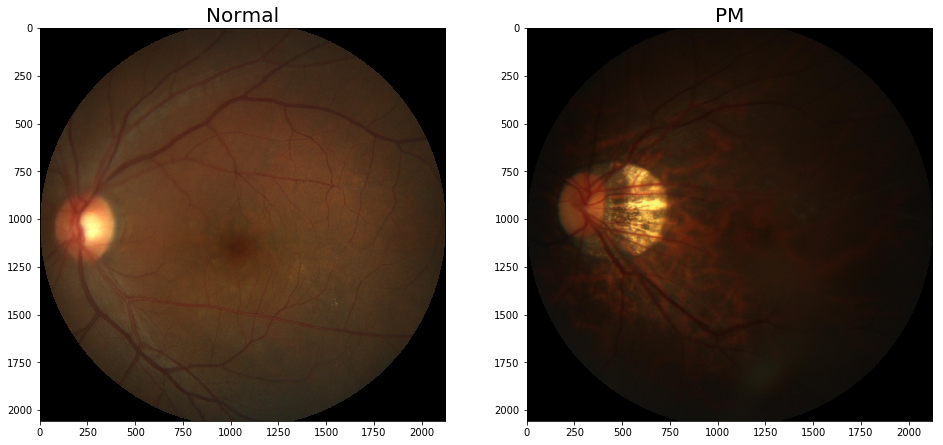

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

DATADIR = '/home/aistudio/work/palm/PALM-Training400/PALM-Training400'
# 文件名以N开头的是正常眼底图片，以P开头的是病变眼底图片
file1 = 'N0012.jpg'
file2 = 'P0095.jpg'

# 读取图片
img1 = Image.open(os.path.join(DATADIR, file1))
img1 = np.array(img1)
img2 = Image.open(os.path.join(DATADIR, file2))
img2 = np.array(img2)

# 画出读取的图片
plt.figure(figsize=(16, 8))
f = plt.subplot(121)
f.set_title('Normal', fontsize=20)
plt.imshow(img1)
f = plt.subplot(122)
f.set_title('PM', fontsize=20)
plt.imshow(img2)
plt.show()

## 模型和训练代码：

In [2]:
import cv2
import random
import numpy as np
import os

# 对读入的图像数据进行预处理
def transform_img(img):
    # 将图片尺寸缩放道 224x224
    img = cv2.resize(img, (224, 224))
    # 读入的图像数据格式是[H, W, C]
    # 使用转置操作将其变成[C, H, W]
    img = np.transpose(img, (2,0,1))
    img = img.astype('float32')
    # 将数据范围调整到[-1.0, 1.0]之间
    img = img / 255.
    img = img * 2.0 - 1.0
    return img

# 定义训练集数据读取器
def data_loader(datadir, batch_size=10, mode = 'train'):
    # 将datadir目录下的文件列出来，每条文件都要读入
    filenames = os.listdir(datadir)
    def reader():
        if mode == 'train':
            # 训练时随机打乱数据顺序
            random.shuffle(filenames)
        batch_imgs = []
        batch_labels = []
        for name in filenames:
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            if name[0] == 'H' or name[0] == 'N':
                # H开头的文件名表示高度近似，N开头的文件名表示正常视力
                # 高度近视和正常视力的样本，都不是病理性的，属于负样本，标签为0
                label = 0
            elif name[0] == 'P':
                # P开头的是病理性近视，属于正样本，标签为1
                label = 1
            else:
                raise('Not excepted file name')
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader

# 定义验证集数据读取器
def valid_data_loader(datadir, csvfile, batch_size=10, mode='valid'):
    # 训练集读取时通过文件名来确定样本标签，验证集则通过csvfile来读取每个图片对应的标签
    # 请查看解压后的验证集标签数据，观察csvfile文件里面所包含的内容
    # csvfile文件所包含的内容格式如下，每一行代表一个样本，
    # 其中第一列是图片id，第二列是文件名，第三列是图片标签，
    # 第四列和第五列是Fovea的坐标，与分类任务无关
    # ID,imgName,Label,Fovea_X,Fovea_Y
    # 1,V0001.jpg,0,1157.74,1019.87
    # 2,V0002.jpg,1,1285.82,1080.47
    # 打开包含验证集标签的csvfile，并读入其中的内容
    filelists = open(csvfile).readlines()
    def reader():
        batch_imgs = []
        batch_labels = []
        for line in filelists[1:]:
            line = line.strip().split(',')
            name = line[1]
            label = int(line[2])
            # 根据图片文件名加载图片，并对图像数据作预处理
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader


In [3]:
# -*- coding: utf-8 -*-
import os
import random
import paddle
import numpy as np

DATADIR = '/home/aistudio/work/palm/PALM-Training400/PALM-Training400'
DATADIR2 = '/home/aistudio/work/palm/PALM-Validation400'
# CSVFILE = '/home/aistudio/labels.csv'
CSVFILE = 'work/palm/PALM-Validation-GT/PM_Label_and_Fovea_Location.csv'

# 定义训练过程
def train_pm(model, optimizer):
    # 开启0号GPU训练
    use_gpu = True
    paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

    print('start training ... ')
    # model.train()
    epoch_num = 10
    # 定义数据读取器，训练数据读取器和验证数据读取器
    train_loader = data_loader(DATADIR, batch_size=10, mode='train')
    valid_loader = valid_data_loader(DATADIR2, CSVFILE)
    for epoch in range(epoch_num):
        for batch_id, data in enumerate(train_loader()):
            x_data, y_data = data
            img = paddle.to_tensor(x_data)
            label = paddle.to_tensor(y_data)
            # 运行模型前向计算，得到预测值
            logits = model(img)
            loss = F.binary_cross_entropy_with_logits(logits, label)
            avg_loss = paddle.mean(loss)

            if batch_id % 10 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
            # 反向传播，更新权重，清除梯度
            avg_loss.backward()
            optimizer.step()
            optimizer.clear_grad()

        model.eval()
        accuracies = []
        losses = []
        for batch_id, data in enumerate(valid_loader()):
            x_data, y_data = data
            img = paddle.to_tensor(x_data)
            label = paddle.to_tensor(y_data)
            # 运行模型前向计算，得到预测值
            logits = model(img)
            # 二分类，sigmoid计算后的结果以0.5为阈值分两个类别
            # 计算sigmoid后的预测概率，进行loss计算
            pred = F.sigmoid(logits)
            loss = F.binary_cross_entropy_with_logits(logits, label)
            # 计算预测概率小于0.5的类别
            pred2 = pred * (-1.0) + 1.0
            # 得到两个类别的预测概率，并沿第一个维度级联
            pred = paddle.concat([pred2, pred], axis=1)
            acc = paddle.metric.accuracy(pred, paddle.cast(label, dtype='int64'))

            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        print("[validation] accuracy/loss: {}/{}".format(np.mean(accuracies), np.mean(losses)))
        model.train()

        paddle.save(model.state_dict(), 'palm.pdparams')
        paddle.save(optimizer.state_dict(), 'palm.pdopt')


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


In [4]:
# -*- coding:utf-8 -*-

# ResNet模型代码
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

# ResNet中使用了BatchNorm层，在卷积层的后面加上BatchNorm以提升数值稳定性
# 定义卷积批归一化块
class ConvBNLayer(paddle.nn.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 filter_size,
                 stride=1,
                 groups=1,
                 act=None):
       
        """
        num_channels, 卷积层的输入通道数
        num_filters, 卷积层的输出通道数
        stride, 卷积层的步幅
        groups, 分组卷积的组数，默认groups=1不使用分组卷积
        """
        super(ConvBNLayer, self).__init__()

        # 创建卷积层
        self._conv = nn.Conv2D(
            in_channels=num_channels,
            out_channels=num_filters,
            kernel_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            bias_attr=False)

        # 创建BatchNorm层
        self._batch_norm = paddle.nn.BatchNorm2D(num_filters)
        
        self.act = act

    def forward(self, inputs):
        y = self._conv(inputs)
        y = self._batch_norm(y)
        if self.act == 'leaky':
            y = F.leaky_relu(x=y, negative_slope=0.1)
        elif self.act == 'relu':
            y = F.relu(x=y)
        return y

# 定义残差块
# 每个残差块会对输入图片做三次卷积，然后跟输入图片进行短接
# 如果残差块中第三次卷积输出特征图的形状与输入不一致，则对输入图片做1x1卷积，将其输出形状调整成一致
class BottleneckBlock(paddle.nn.Layer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 stride,
                 shortcut=True):
        super(BottleneckBlock, self).__init__()
        # 创建第一个卷积层 1x1
        self.conv0 = ConvBNLayer(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=1,
            act='relu')
        # 创建第二个卷积层 3x3
        self.conv1 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            act='relu')
        # 创建第三个卷积 1x1，但输出通道数乘以4
        self.conv2 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters * 4,
            filter_size=1,
            act=None)

        # 如果conv2的输出跟此残差块的输入数据形状一致，则shortcut=True
        # 否则shortcut = False，添加1个1x1的卷积作用在输入数据上，使其形状变成跟conv2一致
        if not shortcut:
            self.short = ConvBNLayer(
                num_channels=num_channels,
                num_filters=num_filters * 4,
                filter_size=1,
                stride=stride)

        self.shortcut = shortcut

        self._num_channels_out = num_filters * 4

    def forward(self, inputs):
        y = self.conv0(inputs)
        conv1 = self.conv1(y)
        conv2 = self.conv2(conv1)

        # 如果shortcut=True，直接将inputs跟conv2的输出相加
        # 否则需要对inputs进行一次卷积，将形状调整成跟conv2输出一致
        if self.shortcut:
            short = inputs
        else:
            short = self.short(inputs)

        y = paddle.add(x=short, y=conv2)
        y = F.relu(y)
        return y

# 定义ResNet模型
class ResNet(paddle.nn.Layer):
    def __init__(self, layers=50, class_dim=1):
        """
        
        layers, 网络层数，可以是50, 101或者152
        class_dim，分类标签的类别数
        """
        super(ResNet, self).__init__()
        self.layers = layers
        supported_layers = [50, 101, 152]
        assert layers in supported_layers, \
            "supported layers are {} but input layer is {}".format(supported_layers, layers)

        if layers == 50:
            #ResNet50包含多个模块，其中第2到第5个模块分别包含3、4、6、3个残差块
            depth = [3, 4, 6, 3]
        elif layers == 101:
            #ResNet101包含多个模块，其中第2到第5个模块分别包含3、4、23、3个残差块
            depth = [3, 4, 23, 3]
        elif layers == 152:
            #ResNet152包含多个模块，其中第2到第5个模块分别包含3、8、36、3个残差块
            depth = [3, 8, 36, 3]
        
        # 残差块中使用到的卷积的输出通道数
        num_filters = [64, 128, 256, 512]

        # ResNet的第一个模块，包含1个7x7卷积，后面跟着1个最大池化层
        self.conv = ConvBNLayer(
            num_channels=3,
            num_filters=64,
            filter_size=7,
            stride=2,
            act='relu')
        self.pool2d_max = nn.MaxPool2D(
            kernel_size=3,
            stride=2,
            padding=1)

        # ResNet的第二到第五个模块c2、c3、c4、c5
        self.bottleneck_block_list = []
        num_channels = 64
        for block in range(len(depth)):
            shortcut = False
            for i in range(depth[block]):
                bottleneck_block = self.add_sublayer(
                    'bb_%d_%d' % (block, i),
                    BottleneckBlock(
                        num_channels=num_channels,
                        num_filters=num_filters[block],
                        stride=2 if i == 0 and block != 0 else 1, # c3、c4、c5将会在第一个残差块使用stride=2；其余所有残差块stride=1
                        shortcut=shortcut))
                num_channels = bottleneck_block._num_channels_out
                self.bottleneck_block_list.append(bottleneck_block)
                shortcut = True

        # 在c5的输出特征图上使用全局池化
        self.pool2d_avg = paddle.nn.AdaptiveAvgPool2D(output_size=1)

        # stdv用来作为全连接层随机初始化参数的方差
        import math
        stdv = 1.0 / math.sqrt(2048 * 1.0)
        
        # 创建全连接层，输出大小为类别数目，经过残差网络的卷积和全局池化后，
        # 卷积特征的维度是[B,2048,1,1]，故最后一层全连接的输入维度是2048
        self.out = nn.Linear(in_features=2048, out_features=class_dim,
                      weight_attr=paddle.ParamAttr(
                          initializer=paddle.nn.initializer.Uniform(-stdv, stdv)))

    def forward(self, inputs):
        y = self.conv(inputs)
        y = self.pool2d_max(y)
        for bottleneck_block in self.bottleneck_block_list:
            y = bottleneck_block(y)
        y = self.pool2d_avg(y)
        y = paddle.reshape(y, [y.shape[0], -1])
        y = self.out(y)
        return y


In [5]:
# 创建模型
model = ResNet()
# 定义优化器
opt = paddle.optimizer.Momentum(learning_rate=0.001, momentum=0.9, parameters=model.parameters(), weight_decay=0.001)
# 启动训练过程
train_pm(model, opt)

start training ... 


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


epoch: 0, batch_id: 0, loss is: [0.83820176]
epoch: 0, batch_id: 10, loss is: [0.6444819]
epoch: 0, batch_id: 20, loss is: [0.7043816]
epoch: 0, batch_id: 30, loss is: [1.1180496]
[validation] accuracy/loss: 0.7324999570846558/0.496967613697052
epoch: 1, batch_id: 0, loss is: [0.54696333]
epoch: 1, batch_id: 10, loss is: [0.7520542]
epoch: 1, batch_id: 20, loss is: [0.45253977]
epoch: 1, batch_id: 30, loss is: [0.25391734]
[validation] accuracy/loss: 0.8975000381469727/0.24625766277313232
epoch: 2, batch_id: 0, loss is: [0.8495647]
epoch: 2, batch_id: 10, loss is: [0.17808655]
epoch: 2, batch_id: 20, loss is: [0.1793255]
epoch: 2, batch_id: 30, loss is: [0.33892292]
[validation] accuracy/loss: 0.8949999809265137/0.24772699177265167
epoch: 3, batch_id: 0, loss is: [0.30973446]
epoch: 3, batch_id: 10, loss is: [0.30824566]
epoch: 3, batch_id: 20, loss is: [0.35566556]
epoch: 3, batch_id: 30, loss is: [0.48471254]
[validation] accuracy/loss: 0.8774999380111694/0.36593687534332275
epoch: 4

通过运行结果可以发现，使用ResNet在眼疾筛查数据集iChallenge-PM上，loss能有效的下降，经过10个epoch的训练，在验证集上的准确率可以达到96%左右。